# Исследование моделей, прогнозирующих пользователям подходящий тариф

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы.

**Задача**: построить модель для задачи классификации, которая cпрогнозирует пользователям подходящий тариф. 

Мы должны построить модель с максимально большим значением метрики качества *accuracy*, но не менее 0.75

# План работы

1. Откроем файл с данными и изучим его. 
2. Разделим исходные данные на обучающую, валидационную и тестовую выборки.
3. Исследуем качество разных моделей, меняя гиперпараметры. 
4. Проверим качество модели на тестовой выборке.
5. Проверим модели на адекватность. 
6. Подведём итоги работы.

# Описание данных

Датасет: https://code.s3.yandex.net/datasets/users_behavior.csv

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

сalls — количество звонков,

minutes — суммарная длительность звонков в минутах,

messages — количество sms-сообщений,

mb_used — израсходованный интернет-трафик в Мб,

is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### Подключение необходимых библиотек

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
%matplotlib inline

#### Игнорируем предупреждения

In [2]:
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

### Объявление кнстант

In [13]:
RS = 12345

## Знакомство с данными

In [3]:
pth_1 = r'C:\Users\Елена Тюлькина\Downloads\users_behavior.csv'
pth_2 = 'users_behavior.csv'

if os.path.exists(pth_1):
    df = pd.read_csv(pth_1)
elif os.path.exists(pth_2):
    df = pd.read_csv(pth_2)
else:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [4]:
display(df.head(10))

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


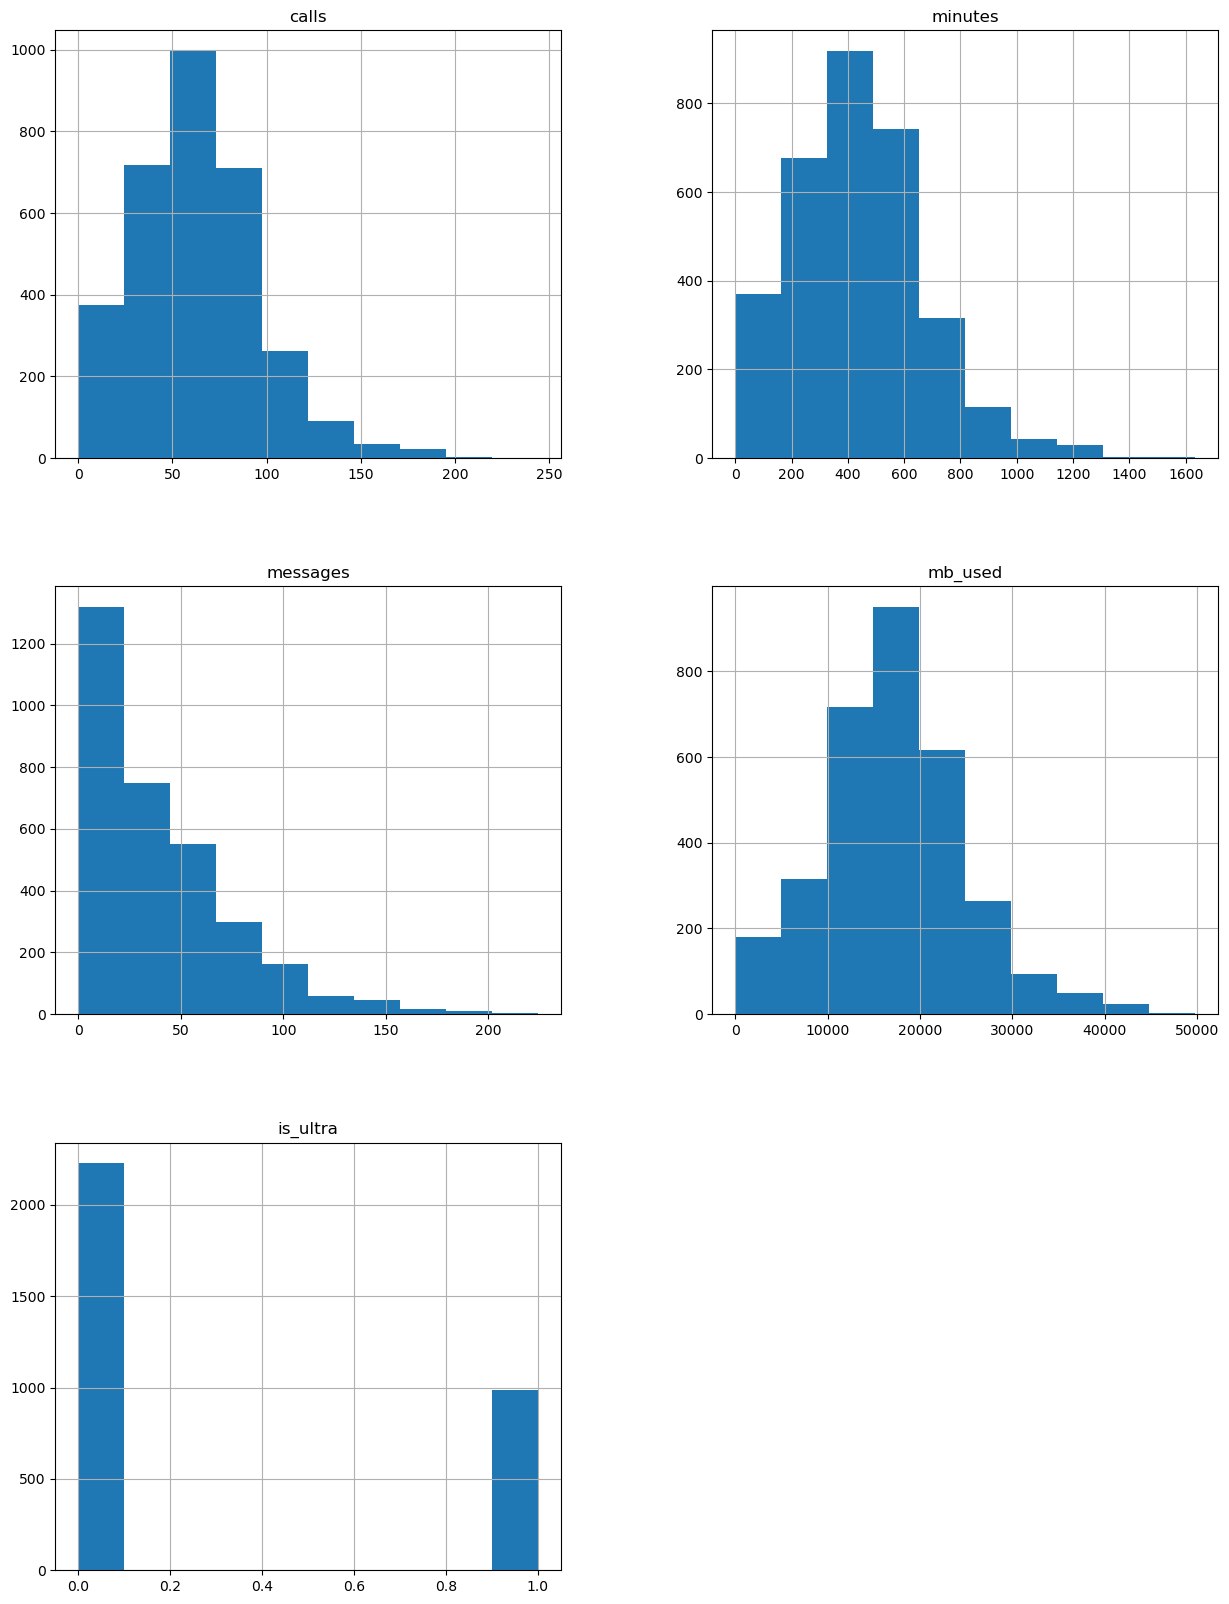

In [7]:
df.hist(figsize=(15, 20));

In [8]:
df.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
print('Форма таблицы:{}'.format(df.shape))

Форма таблицы:(3214, 5)


В представленных данных не обнаружено пропусков и явных дубликатов.

По гистограммам распределение значений близко к распределению Пирсона: с положительной ассиметрией.

Типы данных в каждом столбце соответствующие.

Точек данных = 3214, признаков = 5.

Данные по тарифу распределены неравномерно: пользователей, пользующихся тарифом "ultra", более чем в 2 раза меньше чем пользователей с тарифом "smart".

## Подготовка выборок

Тк у нас нет отдельного тестового набора данных, необходимо имеющийся датасет разделить на 3 выборки:
1. Обучающие данные 
2. Валидационные данные
3. Тестовые данные

Для каждой выборки выделим 60%, 20% и 20% соответственно.

In [14]:
# Для корректного распределения данных по тарифам используем stratify

train, check = train_test_split(df, test_size=0.4, random_state=RS, stratify=df['is_ultra'])

In [15]:
validate, test = train_test_split(check, test_size=0.5, random_state=RS)

In [16]:
print(train.shape)

(1928, 5)


In [17]:
print(validate.shape)

(643, 5)


In [18]:
print(test.shape)

(643, 5)


In [19]:
features_train = train.drop(['is_ultra'], axis=1)

In [20]:
features_train.head()

,calls,minutes,messages,mb_used
2294,76.0,484.49,11.0,22454.35
1759,51.0,328.88,24.0,20511.93
529,105.0,705.05,18.0,22130.74
1599,19.0,135.52,48.0,13152.50
1868,28.0,159.55,0.0,14780.00


In [21]:
features_validate = validate.drop(['is_ultra'], axis=1)

In [22]:
features_validate.head()

,calls,minutes,messages,mb_used
1725,85.0,645.72,0.0,14586.92
2061,66.0,478.48,0.0,16962.58
2440,62.0,466.60,0.0,17353.48
1568,40.0,261.03,72.0,14587.09
2500,48.0,353.63,29.0,24852.78


In [23]:
features_test = test.drop(['is_ultra'], axis=1)

In [24]:
features_test.head()

,calls,minutes,messages,mb_used
3067,62.0,400.64,0.0,17187.89
2947,50.0,292.88,37.0,16415.93
2966,128.0,869.07,0.0,21723.95
751,63.0,411.36,31.0,11886.28
614,69.0,563.78,41.0,21020.21


In [25]:
target_train = train['is_ultra']

In [26]:
target_train

2294    0
1759    0
529     1
1599    0
1868    0
       ..
1967    0
920     1
2456    1
756     0
2134    1
Name: is_ultra, Length: 1928, dtype: int64

In [27]:
target_validate = validate['is_ultra']

In [28]:
target_validate

1725    0
2061    0
2440    0
1568    0
2500    0
       ..
2692    0
2184    0
1569    0
801     0
3110    0
Name: is_ultra, Length: 643, dtype: int64

In [29]:
target_test = test['is_ultra']

In [30]:
target_test

3067    0
2947    0
2966    1
751     0
614     0
       ..
1680    0
2024    0
2317    0
1954    0
2918    1
Name: is_ultra, Length: 643, dtype: int64

Выборки готовы. Приступим к обучению моделей.

## Исследуем модели

В таблицах 5 признаков, выбран целевой, в котором может быть либо одно, либо второе значение. 
В качестве алгоритмов для обучения модели попробуем:
1. Решающее дерево
2. Случайный лес
3. Метод K ближайших соседей
4. Логистическая регрессия

In [31]:
# обучение модели на обучающих выборках и проверка Accuracy на обучающей и валидационной выборках

def fit_acc_model(model_name):
    
    model_name.fit(features_train, target_train)
    
    print("Accuracy на обучающем наборе: {:.3f}".format(model_name.score(features_train, target_train)))
    
    print("Accuracy на валидационном наборе: {:.3f}".format(model_name.score(features_validate, target_validate)))
    
    return

#### Решающее дерево

In [32]:
# Фиксируем псевдослучайность с помощью параметра random_state

model_tree = DecisionTreeClassifier(random_state=RS)

fit_acc_model(model_tree)

Accuracy на обучающем наборе: 1.000
Accuracy на валидационном наборе: 0.717


Валидация показывает, как поведёт себя модель с незнакомыми данными. Правильность предсказаний резко упала - модель переобучена. Обратимся к гиперпарамерам.

Главный в решающем дереве - это max_depth. Если не ограничить глубину, дерево может быть сколь угодно глубоким и сложным. Поэтому необрезанные деревья склонны к переобучению и плохо обобщают результат на новые данные. 

Переберём значения для определения лучшей глубины.

In [33]:
for depth in range(1, 6):
    
    model_tree_2 = DecisionTreeClassifier(max_depth=depth,  random_state=RS)
    
    model_tree_2.fit(features_train, target_train) 
    
    predictions_validate =  model_tree_2.predict(features_validate) 
    
    print("max_depth =", depth, ": ", end='')
    print(accuracy_score(target_validate, predictions_validate))

max_depth = 1 : 0.7309486780715396
max_depth = 2 : 0.7698289269051322
max_depth = 3 : 0.8009331259720062
max_depth = 4 : 0.7651632970451011
max_depth = 5 : 0.8055987558320373


Лучшее значение для гиперпараметра max_depth = 5. Зафиксируем это в нашей модели.

In [34]:
model_tree = DecisionTreeClassifier(max_depth=5, random_state=RS)

fit_acc_model(model_tree)

Accuracy на обучающем наборе: 0.814
Accuracy на валидационном наборе: 0.806


Проверим эту же модель с другими значениями гиперпараметра criterion: по умолчанию, у model_tree он равен "gini".

In [35]:
# criterion='entropy'

model_tree_entropy = DecisionTreeClassifier(max_depth=5, random_state=RS, criterion='entropy')

fit_acc_model(model_tree_entropy)

Accuracy на обучающем наборе: 0.812
Accuracy на валидационном наборе: 0.804


Хоть правильность моделей по сравнению с model_tree на обучающем наборе снизилась, она стала близкой к правильности на валидационном наборе. Выигрывает модель с гиперпараметром criterion="gini", у неё показатели лучше на 0.002.

Визуализируем данную модель.

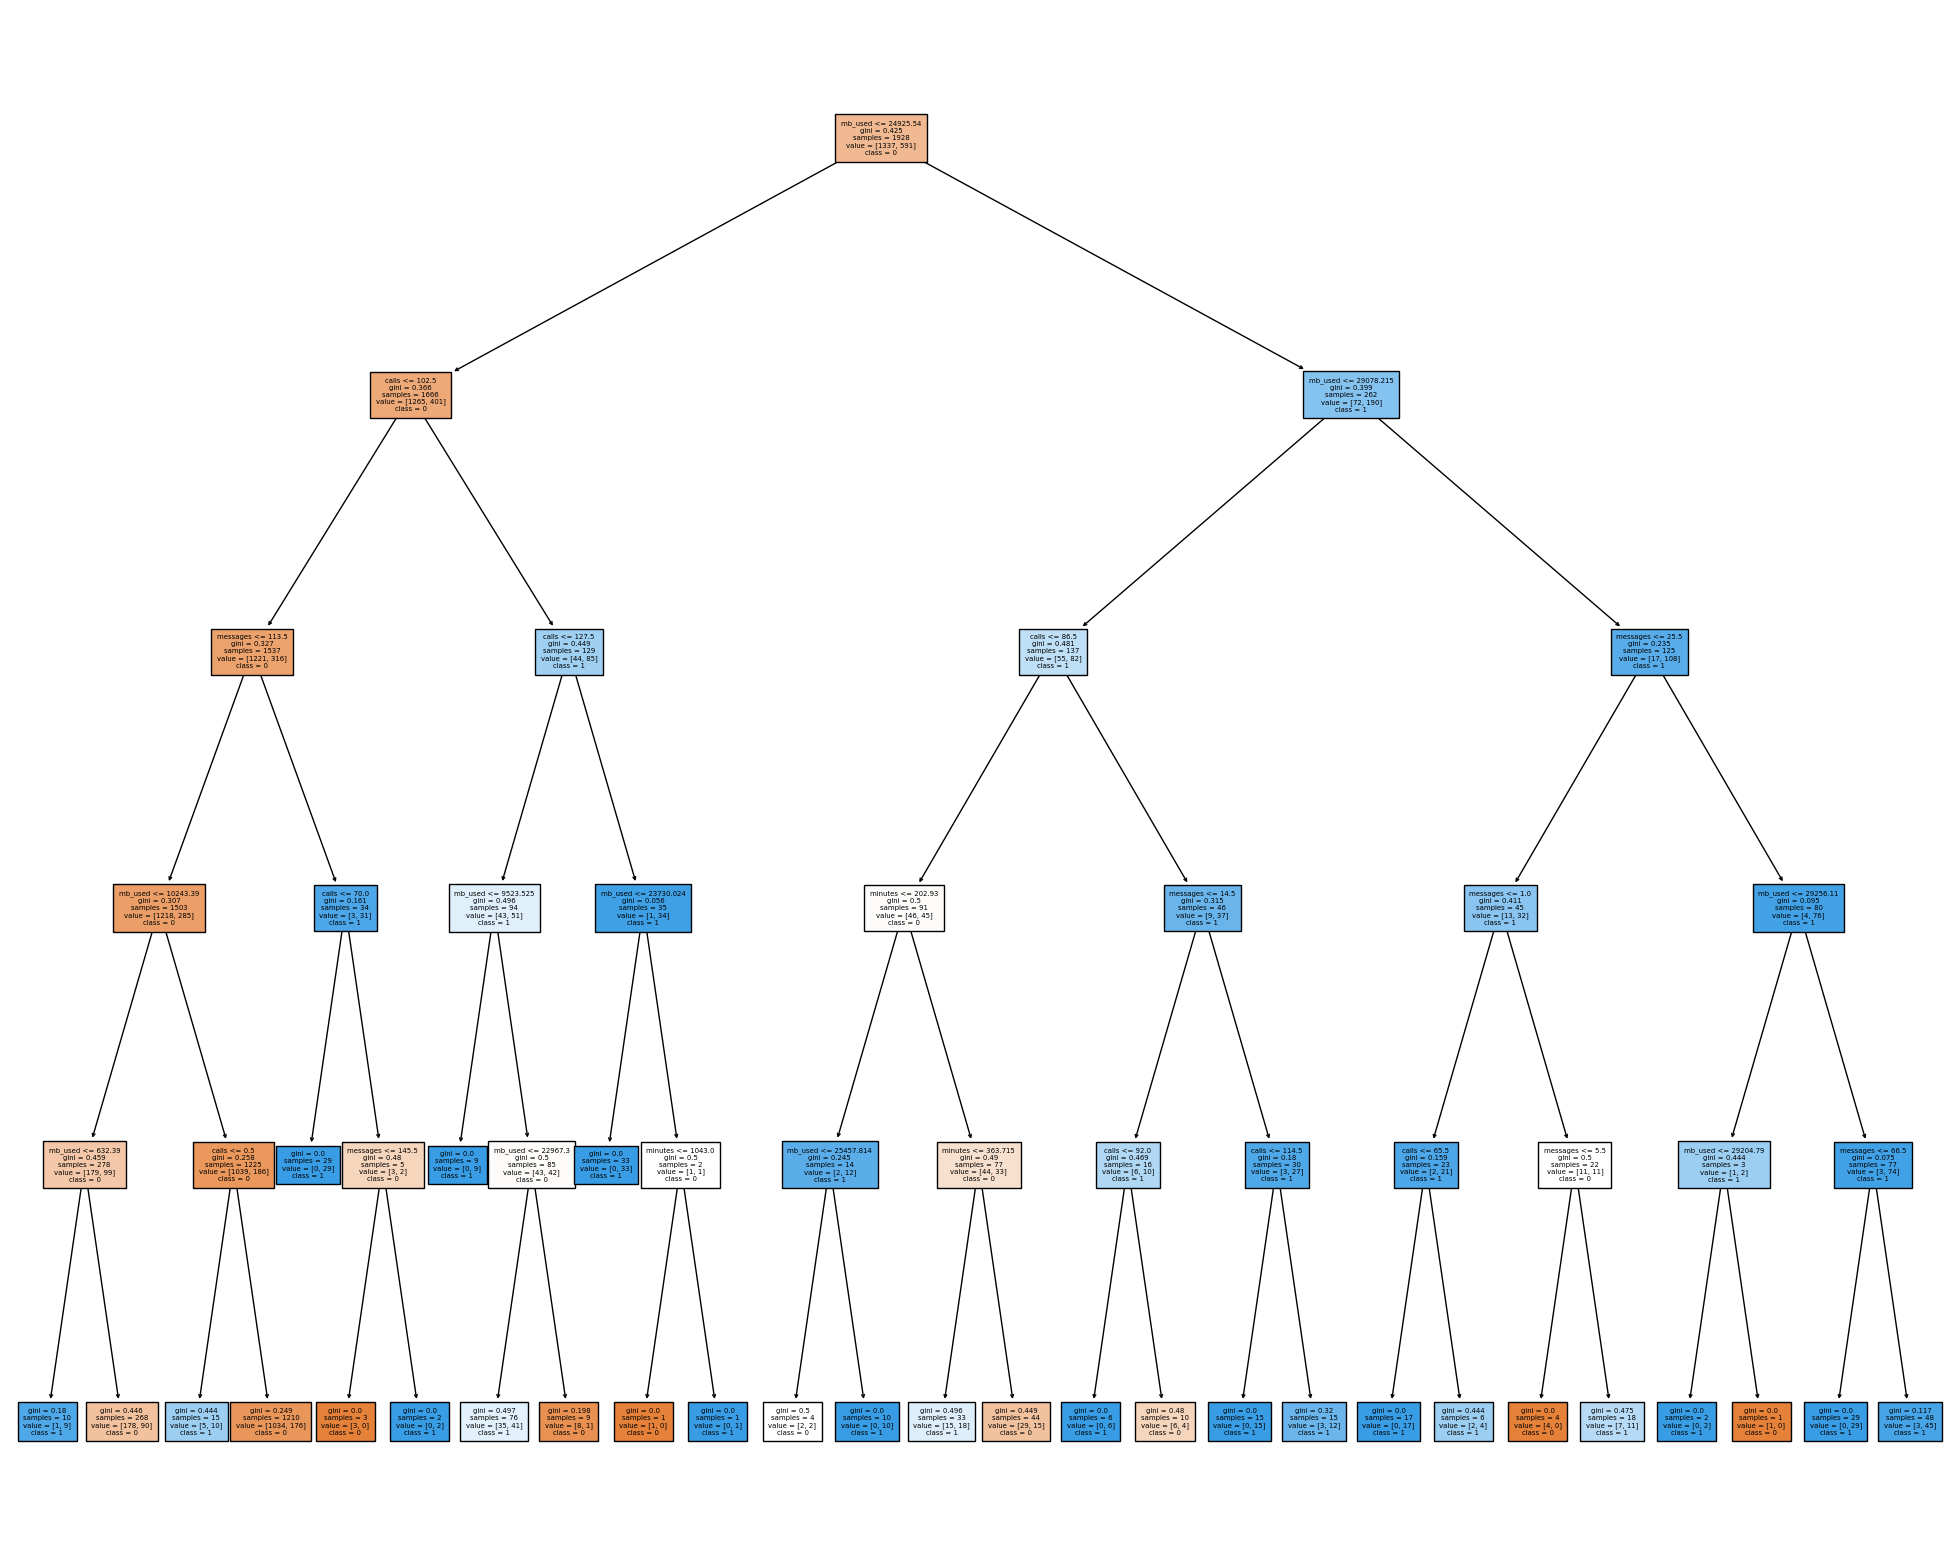

In [36]:
fig = plt.figure(figsize=(25,20)) 

tree.plot_tree(model_tree, feature_names=features_train.columns,  
                   class_names=["0", "1"],
                   filled=True,
                   fontsize=5)

plt.show() 

Таким образом, у нас получилось обучить модель, которая примерно на одинаковом уровне (0.8) показывает правильность работы.

#### Случайный лес

В данном алгоритме 2 гиперпараметра, которые нужно вычислить, чтобы построить удачную модель: помимо глубины леревьев, нужно понять, какое количество "деревьев сажать в лесу".
Реализуем это с помощью цикла.

In [37]:
# соберем значения accuracy и гиперпараметров в списки, из которых потом создадим датафрейм

accuracy_forest = []
max_depth_forest = []
n_estimators = []

In [38]:
for depth in range(2, 16):
    for trees in range(2, 250, 15):
        
        model_forest = RandomForestClassifier(random_state=RS, max_depth=depth, n_estimators=trees)
        
        model_forest.fit(features_train, target_train)
        
        predictions_validate =  model_forest.predict(features_validate) 
        
        accuracy_r_forest = round(accuracy_score(target_validate, predictions_validate), 4)
        
        accuracy_forest.append(accuracy_r_forest)
        max_depth_forest.append(depth)
        n_estimators.append(trees)

In [39]:
# собираем все списки в один

forest_info = [max_depth_forest, n_estimators, accuracy_forest]

# создаем датафрейм

forest_info = pd.DataFrame({'max_depth':max_depth_forest, 'n_estimators':n_estimators, 'accuracy':accuracy_forest})

display(forest_info)

,max_depth,n_estimators,accuracy
0,2,2,0.7667
1,2,17,0.7916
2,2,32,0.8040
3,2,47,0.8056
4,2,62,0.8072
...,...,...,...
233,15,182,0.8180
234,15,197,0.8212
235,15,212,0.8212
236,15,227,0.8212


In [40]:
display(forest_info[forest_info['accuracy'] == forest_info['accuracy'].max()])

,max_depth,n_estimators,accuracy
129,9,152,0.8305


Получили лучшие показатели для параметров: глубина - 9,  деревьев - 152

In [41]:
random_forest_model = RandomForestClassifier(random_state=RS, max_depth=9, n_estimators=152) 

fit_acc_model(random_forest_model)

Accuracy на обучающем наборе: 0.883
Accuracy на валидационном наборе: 0.830


Проверим эту же модель с другими значениями гиперпараметра criterion: по умолчанию, у model_tree он равен "gini".

In [42]:
# criterion='entropy'

random_forest_model_entropy = RandomForestClassifier(random_state=RS, max_depth=9, n_estimators=152, criterion='entropy')

fit_acc_model(random_forest_model_entropy)

Accuracy на обучающем наборе: 0.882
Accuracy на валидационном наборе: 0.821


С criterion='entropy' accuracy чуть ниже.

Мы достигли близких друг к другу Accuracy на обучающей и валидационной выборках у модели случайного леса со значением параметра  criterion="gini".

#### k ближайших соседей

Самым важным параметром KNeighborsClassifier является количество соседей. Используем цикл, аналогичный предыдущим, чтобы выбрать лучшее значение для параметра n_neighbors.

In [43]:
for neighbor in range(1, 11):
    
    k_model = KNeighborsClassifier(n_neighbors=neighbor)
    
    k_model.fit(features_train, target_train) 
    
    predictions_validate =  k_model.predict(features_validate) 
    
    print("max_neighbor =", neighbor, ": ", end='')
    print(accuracy_score(target_validate, predictions_validate))

max_neighbor = 1 : 0.7153965785381027
max_neighbor = 2 : 0.7573872472783826
max_neighbor = 3 : 0.7589424572317263
max_neighbor = 4 : 0.76049766718507
max_neighbor = 5 : 0.7651632970451011
max_neighbor = 6 : 0.7636080870917574
max_neighbor = 7 : 0.7651632970451011
max_neighbor = 8 : 0.7698289269051322
max_neighbor = 9 : 0.7729393468118196
max_neighbor = 10 : 0.7651632970451011


Модель с 9 соседями показывает более высокое значение accuracу

In [44]:
k_model = KNeighborsClassifier(n_neighbors=9)

fit_acc_model(k_model)

Accuracy на обучающем наборе: 0.782
Accuracy на валидационном наборе: 0.773


Проверим эту же модель с другим значением параметра weights. Выше, по умолчанию, он имел значение "uniform".

In [45]:
for neighbor in range(1, 11):
    
    k_model = KNeighborsClassifier(n_neighbors=neighbor, weights="distance")
    
    k_model.fit(features_train, target_train) 
    
    predictions_validate =  k_model.predict(features_validate) 
    
    print("max_neighbor =", neighbor, ": ", end='')
    print(accuracy_score(target_validate, predictions_validate))

max_neighbor = 1 : 0.7153965785381027
max_neighbor = 2 : 0.7153965785381027
max_neighbor = 3 : 0.7480559875583204
max_neighbor = 4 : 0.7387247278382582
max_neighbor = 5 : 0.7620528771384136
max_neighbor = 6 : 0.7682737169517885
max_neighbor = 7 : 0.7636080870917574
max_neighbor = 8 : 0.7713841368584758
max_neighbor = 9 : 0.7682737169517885
max_neighbor = 10 : 0.7651632970451011


In [46]:
k_model_dist = KNeighborsClassifier(n_neighbors=8, weights="distance")

fit_acc_model(k_model_dist)

Accuracy на обучающем наборе: 1.000
Accuracy на валидационном наборе: 0.771


И в итоге с параметром weights="distance" получили переобученную модель.

И на обучающем, и на валидационном наборе примерно одинаковое значение accuracy. Но модель показывает не очень высокую точность классификации.

#### Логистическая регрессия

In [47]:
model_log_reg = LogisticRegression(random_state=RS, max_iter=1000)

fit_acc_model(model_log_reg)

Accuracy на обучающем наборе: 0.751
Accuracy на валидационном наборе: 0.737


Переберём параметр "solver" и соответствующие значения параметра "penalty"

In [48]:
penalty_lbfgs = ["l2", "none"]

In [49]:
for p in penalty_lbfgs:
    
    model_lr_1 = LogisticRegression(random_state=RS, solver='lbfgs', max_iter=1000, penalty=p)
    
    model_lr_1.fit(features_train, target_train) 
    
    predictions_validate =  model_lr_1.predict(features_validate) 
    
    print("pen =", p, ": ", end='')
    print(accuracy_score(target_validate, predictions_validate))

pen = l2 : 0.7371695178849145
pen = none : 0.7371695178849145


In [50]:
penalty_liblinear = ["l1", "l2"]

In [51]:
for p in penalty_liblinear:
    
    model_lr_2 = LogisticRegression(random_state=RS, solver='liblinear', max_iter=1000, penalty=p)
    
    model_lr_2.fit(features_train, target_train) 
    
    predictions_validate =  model_lr_2.predict(features_validate) 
    
    print("pen =", p, ": ", end='')
    print(accuracy_score(target_validate, predictions_validate))

pen = l1 : 0.7371695178849145
pen = l2 : 0.7216174183514774


In [52]:
model_log_reg_1 =  LogisticRegression(random_state=RS, solver='lbfgs', max_iter=1000, penalty='l2')

fit_acc_model(model_log_reg_1)

Accuracy на обучающем наборе: 0.751
Accuracy на валидационном наборе: 0.737


In [53]:
model_log_reg__2 = LogisticRegression(random_state=RS, solver='liblinear', max_iter=1000, penalty='l1')

fit_acc_model(model_log_reg__2)

Accuracy на обучающем наборе: 0.750
Accuracy на валидационном наборе: 0.737


Модель model_log_reg_1 с параметрами solver='lbfgs' и penalty='l2' дала немного более высокую точность. Определим, какую степень регуляризации лучше применить.

In [54]:
for cc in range(1, 1001, 50):
    
    predictions_validate =  model_log_reg_1.predict(features_validate) 
    
    print("max_c =", cc, ": ", end='')
    print(accuracy_score(target_validate, predictions_validate))

max_c = 1 : 0.7371695178849145
max_c = 51 : 0.7371695178849145
max_c = 101 : 0.7371695178849145
max_c = 151 : 0.7371695178849145
max_c = 201 : 0.7371695178849145
max_c = 251 : 0.7371695178849145
max_c = 301 : 0.7371695178849145
max_c = 351 : 0.7371695178849145
max_c = 401 : 0.7371695178849145
max_c = 451 : 0.7371695178849145
max_c = 501 : 0.7371695178849145
max_c = 551 : 0.7371695178849145
max_c = 601 : 0.7371695178849145
max_c = 651 : 0.7371695178849145
max_c = 701 : 0.7371695178849145
max_c = 751 : 0.7371695178849145
max_c = 801 : 0.7371695178849145
max_c = 851 : 0.7371695178849145
max_c = 901 : 0.7371695178849145
max_c = 951 : 0.7371695178849145


Таким образом, размер гиперпараметра силы регуляризации не помог повысить значение Accuracy. Рассмотрим также веса признаков:

In [55]:
model_log_reg_1.coef_

array([[ 1.31326719e-02, -5.03257444e-04,  1.07303262e-02,
         4.00855973e-05]])

Каждый из признаков имеет значение, проводить эксперименты и удалять признаки не требуется.

На всех изученных моделях логистической регрессии правильность довольно низкая. Accuracy даже ниже, чем у модели k ближайших соседей.

**Исследуя 4 модели, мы:**
- Работали с 3-мя параметрами для модели решающего дерева: max_depth, criterion и random_state. Обучили модель, которая примерно на одинаковом уровне (0.8) показывает правильность работы.
- Обозначили 4 параметра для модели случайного леса: random_state, max_depth, n_estimators и criterion. Данная модель показала самую высокую точность классификации (примерно 8.4)
- Определили n_neighbors и weights для модели К ближайших соседей, но получили правильность на уровне примерно 7.8
- Обозначили 4 параметра для модели логистической регрессии random_state, solver, max_iter, penalty; Так же проверили веса признаков, но получили самые низкие показатели accuracy.

Таким образом, лучшие результаты показала модель случайного леса.

## Проверим модель на тестовой выборке

In [56]:
print("Правильность на тестовом наборе: {:.3f}".format(random_forest_model.score(features_test, target_test)))

Правильность на тестовом наборе: 0.807


Мы достигли поставленной цели: Accuracy > 0.75

## Проверим модели на адекватность

с помощью **baseline** модели.

In [57]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=RS)

fit_acc_model(dummy_clf)

Accuracy на обучающем наборе: 0.693
Accuracy на валидационном наборе: 0.692


In [58]:
print("Правильность на тестовом наборе: {:.3f}".format(dummy_clf.score(features_test, target_test)))

Правильность на тестовом наборе: 0.695


Accuracy на dummy_clf модели гораздо ниже. Наша более сложная модель действительно дает нам прирост качества.

## Общий вывод.

Для работы был представлен датафрейм следующй формы: точек данных = 3214, признаков = 5. При этом пользователей с тарифом "ultra" представлено в 2 раза меньше.

Мы разделили данные на 3 выборки:
1. Обучающие данные (60%);
2. Валидационные данные (20%);
3. Тестовые данные (20%)
Из 5 признаков мы выбрали целевой - столбец 'is_ultra'.

Мы исследовали 4 модели с разными алгоритмами:
1. Модель решающего дерева;
2. Модель случайного леса;
3. Модель К случайных соседей;
4. Модель логистической регрессии.

Лучшую метрику качества Accuracy показала модель случайного леса, худшую - модель логистической регрессии. 
Для модели случайного леса мы указали 4 параметра: random_state, max_depth, n_estimators и criterion.

На тестовом наборе случайный лес показал Accuracy > 0.75.
Мы также проверили модель на адекватность: сравнили Accuracy нашей сложной модели с Accuracy baseline моделью. Наша модель удачно прошла проверку.